# Network 1

For the results of this notebook 300 000 samples have been generated, which took in 9949.76 sec.

1/4 was kept for the validation and another 1/4 for the predictions

Which means the networks have been trained on 150 000 samples

Training on even more data could be interesting but unfortunately the data files take a lot of space and 

The parameters that have influence on the results of a network are
- hyperparameters: dropout, learning rate, size of network, ...
- the data: the type of noise, the number of samples for the training
- the training parameters: batchsize, number of epochs

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn.parameter import Parameter

path_to_utils = os.path.join('.', 'python_functions')
path_to_utils = os.path.abspath(path_to_utils)

if path_to_utils not in sys.path:
    sys.path.insert(0, path_to_utils)

import mf_utils as util
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import time

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from scipy import stats


### Loading the training data

In [2]:
# %% Train data

print('----------------------- Data --------------------------')

#Do not change! because the targets from the pickle file are not adapted for non noisy data
#(In the python file the change can be made)
use_noise = True 

num_params = 6
num_fasc = 2
M0 = 500
num_atoms = 782

filename = 'ID_noisy_data_big' 
IDs = pickle.load(open(filename, 'rb'))

filename = 'nus_data_big' 
nus = pickle.load(open(filename, 'rb'))

if use_noise:
    filename = 'dw_noisy_data_big'
    data = pickle.load(open(filename, 'rb'))
else:
    filename = 'dw_image_data_big'
    data = pickle.load(open(filename, 'rb'))


M, num_sample = data.shape #M=552
num_div = num_sample/4

print('M', M) 
print('num_sample', num_sample)

params1 = {
    #Training parameters
    "num_samples": num_sample,
     "batch_size": 250,  
     "num_epochs": 30,
     
     #NW2
     "num_h1": 250,
     "num_h2": 400,
     "num_h3": 500,
     "num_h4": 500,
     "num_h5": 50,
     
     #other
     "learning_rate": 0.0005,
     #"learning_rate": hp.choice("learningrate", [0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002]),
     "dropout": 0.2
     #"dropout": hp.uniform("dropout", 0, 0.4)
}

# divide data in train, test and validation
x_train = data[:, 0:int(2*num_div)]
x_test = data[:, int(2*num_div) : int(3*num_div) ]
x_valid = data[:, int(3*num_div) : int(4*num_div) ]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
x_valid = torch.from_numpy(x_valid)

#print(x_train)
print('x_train size', x_train.shape)
print('x_test size', x_test.shape)
print('x_valid size', x_valid.shape)

#quelques modifs pour le modele neuronal
x_train = x_train.float()
x_train = torch.transpose(x_train, 0, 1) 
x_test = x_test.float()
x_test = torch.transpose(x_test, 0, 1) 
x_valid = x_valid.float()
x_valid = torch.transpose(x_valid, 0, 1) 

----------------------- Data --------------------------
M 552
num_sample 300000
x_train size torch.Size([552, 150000])
x_test size torch.Size([552, 75000])
x_valid size torch.Size([552, 75000])


### Loading the targets

In [3]:
print("--- Taking microstructural properties of fascicles ---")

filename = 'NW1targets' 
parameters = pickle.load(open(filename, 'rb'))

## TARGET DATA ###

target_params = np.zeros((6, num_sample))

target_params[0,:] = nus[:,0]
target_params[1,:] = parameters['subinfo']['rad'][IDs[:,0]]
target_params[2,:] = parameters['subinfo']['fin'][IDs[:,0]]
target_params[3,:] = nus[:,1]
target_params[4,:] = parameters['subinfo']['rad'][IDs[:,1]]
target_params[5,:] = parameters['subinfo']['fin'][IDs[:,1]]

print('target_params', target_params.shape)

# Standardisation
scaler1 = StandardScaler()
target_params = scaler1.fit_transform(target_params.T)
target_params = target_params.T

# Dividing in train test and valid
target_train = target_params[:, 0:int(2*num_div)]
target_test = target_params[:, int(2*num_div) : int(3*num_div) ]
target_valid = target_params[:, int(3*num_div) : int(4*num_div) ]

print('target_train size', target_train.shape)
print('target_test size', target_test.shape)
print('target_valid size', target_valid.shape)

#quelques modifs pour le modele neuronal
target_train = torch.from_numpy(target_train).float()
target_train = torch.transpose(target_train, 0, 1) 
target_test = torch.from_numpy(target_test).float()
target_test = torch.transpose(target_test, 0, 1) 
target_valid = torch.from_numpy(target_valid).float()
target_valid = torch.transpose(target_valid, 0, 1) 


--- Taking microstructural properties of fascicles ---
target_params (6, 300000)
target_train size (6, 150000)
target_test size (6, 75000)
target_valid size (6, 75000)


### Building the Network

In [4]:
# %% Building the network

class Net1(nn.Module):

    def __init__(self, num_in, num_h1, num_h2, num_h3, num_h4, num_h5, num_out, drop_prob):
        super(Net1, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h1, num_in)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_h1), 0))
        self.l1_bn = nn.BatchNorm1d(num_h1)
        # hidden layer
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h2, num_h1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_h2), 0))
        self.l2_bn = nn.BatchNorm1d(num_h2)
        #second hidden layer
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h3, num_h2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_h3), 0))
        
        self.W_4 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h4, num_h3)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_h4), 0))
        
        self.W_5 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h5, num_h4)))
        self.b_5 = Parameter(init.constant_(torch.Tensor(num_h5), 0))
        
        self.W_6 = Parameter(init.kaiming_uniform_(torch.Tensor(num_out, num_h5)))
        self.b_6 = Parameter(init.constant_(torch.Tensor(num_out), 0))
        
        #self.W_3_bn = nn.BatchNorm2d(num_out)
        # define activation function in constructor
        self.activation = torch.nn.ReLU()
        
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):

        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x)

        x = F.linear(x, self.W_2, self.b_2)
        #x = self.l1_bn(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_4, self.b_4)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_5, self.b_5)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_6, self.b_6)

        return x

### Building the Training loop

In [6]:
def train_network1(params1: dict):
    # Building training loop
    num_in = 552
    num_out = num_params
    num_h1 = params1["num_h1"]
    num_h2 = params1["num_h2"]
    num_h3 = params1["num_h3"] 
    num_h4 = params1["num_h4"]
    num_h5 = params1["num_h5"]
    drop_prob = params1["dropout"]
    
    net1 = Net1(num_in, num_h1, num_h2, num_h3, num_h4, num_h5, num_out, drop_prob)
    
    print(net1)
    
    # Optimizer and Criterion
    optimizer = optim.Adam(net1.parameters(), lr=params1["learning_rate"], weight_decay=0.0000001)
    lossf = nn.MSELoss()

    print('----------------------- Training --------------------------')
    
    # setting hyperparameters and gettings epoch sizes
    batch_size = params1["batch_size"] #100 
    num_epochs = params1["num_epochs"] 
    num_samples_train = x_train.shape[0]
    num_batches_train = num_samples_train // batch_size #??
    num_samples_valid = x_valid.shape[0]
    num_batches_valid = num_samples_valid // batch_size
    
    # setting up lists for handling loss/accuracy
    train_acc = np.zeros((num_epochs, num_params))
    valid_acc = np.zeros((num_epochs, num_params))
    
    meanTrainError, meanValError  = [], []
    
    cur_loss = 0
    losses = []
    
    # lambda function
    get_slice = lambda i, size: range(i * size, (i + 1) * size)
    
    for epoch in range(num_epochs):
        # Forward -> Backprob -> Update params
        ## Train
        cur_loss = 0
        net1.train()
        for i in range(num_batches_train):
            
            optimizer.zero_grad()
            slce = get_slice(i, batch_size)
            output = net1(x_train[slce])
            
            # compute gradients given loss
            target_batch = target_train[slce]
            batch_loss = lossf(output, target_batch)
            batch_loss.backward()
            optimizer.step()
            
            cur_loss += batch_loss   
        losses.append(cur_loss / batch_size)
    
        net1.eval()
        
        ### Evaluate training
        train_preds = [[], [], [], [], [], []]
        train_targs = [[], [], [], [], [], []]
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            preds = net1(x_train[slce, :])
            
            for j in range(num_params):
                train_targs[j] += list(target_train[slce, j].numpy())
                train_preds[j] += list(preds.data[:,j].numpy())
            
        ### Evaluate validation
        val_preds = [[], [], [], [], [], []]
        val_targs = [[], [], [], [], [], []]
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size)
            preds = net1(x_valid[slce, :])
            
            for j in range(num_params):
                val_targs[j] += list(target_valid[slce, j].numpy())
                val_preds[j] += list(preds.data[:,j].numpy())
                
        # Save evaluation and training
        train_acc_cur = np.zeros(num_params)
        valid_acc_cur = np.zeros(num_params)
        for j in range(num_params):
            train_acc_cur[j] = mean_absolute_error(train_targs[j], train_preds[j])
            valid_acc_cur[j] = mean_absolute_error(val_targs[j], val_preds[j])
            train_acc[epoch, j] = train_acc_cur[j]
            valid_acc[epoch, j] = valid_acc_cur[j]
        
        meanTrainError.append(np.mean(train_acc[epoch,:]))
        meanValError.append(np.mean(valid_acc[epoch, :]))
        
        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f, " %(
                    epoch+1, losses[-1], meanTrainError[-1], meanValError[-1]))
        
    to_min = sum(valid_acc_cur)
      
    return {"loss": to_min, 
            "model": net1, 
            "params": params1, 
            "status": STATUS_OK,
            "train_acc": train_acc,
            "valid_acc": valid_acc,
            "meanTrainError": meanTrainError,
            "meanValError": meanValError
            }

### Training the Network

In [7]:
tic = time.time()
trial = train_network1(params1)  
toc = time.time()

print("training time:", toc-tic, "[sec]")

Net1(
  (l1_bn): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2_bn): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
----------------------- Training --------------------------
Epoch  1 : Train Loss 1.237451 , Train acc 0.452922, Valid acc 0.455290, 
Epoch 11 : Train Loss 0.760064 , Train acc 0.381962, Valid acc 0.387811, 
Epoch 21 : Train Loss 0.693658 , Train acc 0.352937, Valid acc 0.362331, 
training time: 848.7546191215515 [sec]


### Graphs for learning

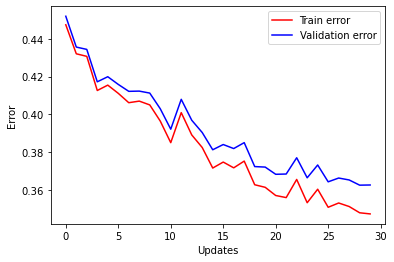

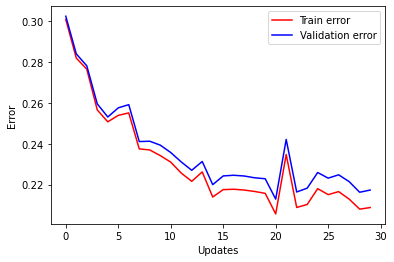

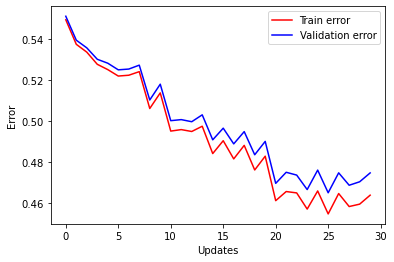

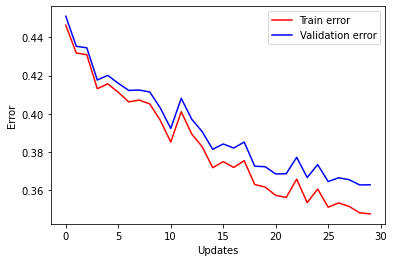

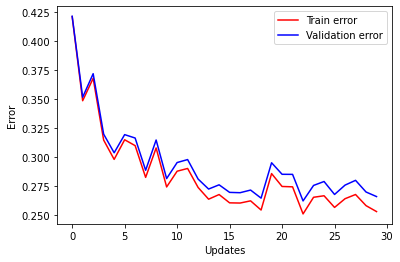

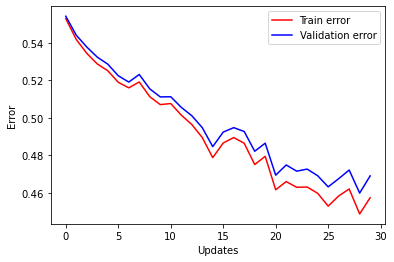

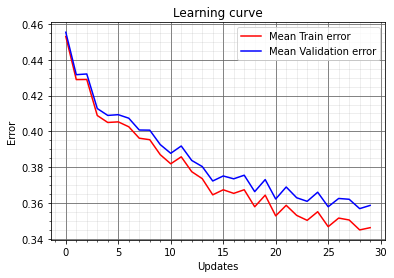

In [9]:
#%% Graphs

train_acc = trial['train_acc']
valid_acc = trial['valid_acc']
epoch = np.arange(trial['params']['num_epochs'])

meanTrainError = trial['meanTrainError']
meanValError = trial['meanValError']

# Graphs of learning curve for every parameter
for j in range(6):    
    plt.figure()
    plt.plot(epoch, train_acc[:, j], 'r', epoch, valid_acc[:, j], 'b')
    plt.legend(['Train error','Validation error'])
    plt.xlabel('Updates'), plt.ylabel('Error')
    plt.show()

# Mean Error
plt.figure()
plt.plot(epoch, meanTrainError, 'r', epoch, meanValError, 'b')
plt.title('Learning curve')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend(['Mean Train error','Mean Validation error'])
plt.xlabel('Updates'), plt.ylabel('Error')
plt.show()

### Predictions

torch.Size([75000, 552])
mean_abs_err [0.36333275 0.21746664 0.47663417 0.36333355 0.26555976 0.46740249]


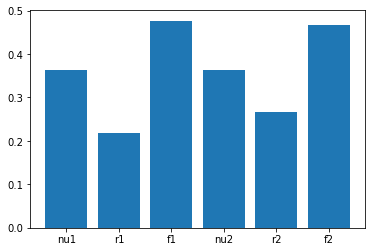

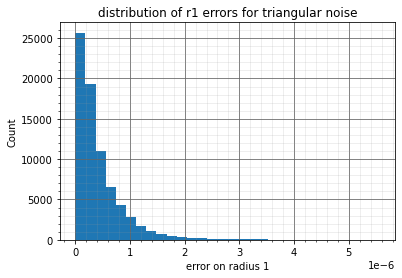

4.2674088e-07


In [10]:
net = trial['model']

print(x_test.shape)
output = net(x_test)
output = output.detach().numpy()

mean_err_scaled = np.zeros(6)
for i in range(6):
    mean_err_scaled[i] = mean_absolute_error(output[:,i], target_test[:,i])

print("mean_abs_err", mean_err_scaled)

properties = ['nu1', 'r1', 'f1', 'nu2', 'r2', 'f2']
plt.figure()
plt.bar(properties, mean_err_scaled)

output = scaler1.inverse_transform(output)
target_scaled = scaler1.inverse_transform(target_test)

error = output - target_scaled

abserror = abs(error)

plt.figure()
plt.title('distribution of r1 errors for triangular noise')
plt.hist(abserror[:,1], density=False, bins=30)  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('error on radius 1')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

print(np.mean(abserror[:,1]))


### Confidence intervals

In [11]:
conf_int = np.zeros(num_params)

for j in range(num_params):
    data = error[:,j]
    
    mean = np.mean(data)
    sigma = np.std(data)
    
    confint = stats.norm.interval(0.95, loc=mean, 
        scale=sigma)
    
    print(confint)

(-0.16451031664832058, 0.19898308763726177)
(-1.231179418098621e-06, 1.2317856378952049e-06)
(-0.2564219697155949, 0.2142417779901024)
(-0.19898393089182703, 0.16450970703966944)
(-1.508805388286363e-06, 1.4488439089490736e-06)
(-0.24901127252790128, 0.2147916089377085)
